# 1 Introducción

El siguiente ejercicio se realiza la suma / resta de dos matrices cuadradas siguiendo la fórmula:

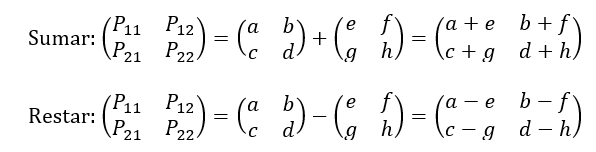

El objetivo es demostrar el trabajo en dos dimensiones de manera secuencial (complejidad O^2) utilzando CUDA y su paradigma multidimencional (hilos para acceder a las filas y a las columnas a la vez).


---
# 2 Armado del ambiente:



In [ ]:
#@title ## 2.1 Parámetros de ejecución
#@markdown ### Especifique el inicio del rango de la matriz
inicio_rango =   11#@param {type: "number"}
#@markdown ### Especifique el fin del rango de la matriz
fin_rango =   18#@param {type: "number"}


#@markdown ### Especifique qué operacion desea realizar
operacion = "Restar" #@param ["Sumar", "Restar"]

#@markdown ### Especifique el tamaño de la matriz
tamano_matriz =   8000#@param {type: "number"}


#Instalación de CUDA 
!pip install pycuda

# 3 Desarrollo

In [ ]:
try:
  from datetime import datetime

  tiempo_total = datetime.now()

  import numpy
  import pycuda.driver as cuda
  import pycuda.autoinit
  from pycuda.compiler import SourceModule


  # --------------------------------------------
  # Definición de función que transforma el tiempo en  milisegundos 
  tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
  # --------------------------------------------

  #inicializo las matrices cuadradas con valores random dentro del rango ingresado por el usuario
  matriz_a = (fin_rango - inicio_rango) * numpy.random.random((tamano_matriz, tamano_matriz)) + inicio_rango
  matriz_a = matriz_a.astype(numpy.float32)
  matriz_b = (fin_rango - inicio_rango) * numpy.random.random((tamano_matriz, tamano_matriz)) + inicio_rango
  matriz_b = matriz_b.astype(numpy.float32)
  matriz_resultado = (fin_rango - inicio_rango) * numpy.random.random((tamano_matriz, tamano_matriz)) + inicio_rango
  matriz_resultado = matriz_resultado.astype(numpy.float32)

  #Reservo espacio en memoria GPU


  matriz_a_gpu = cuda.mem_alloc(matriz_a.nbytes)
  matriz_b_gpu = cuda.mem_alloc(matriz_b.nbytes)
  matriz_resultado_gpu = cuda.mem_alloc(matriz_resultado.nbytes)


  #copio las matrices a GPU
  cuda.memcpy_htod(matriz_a_gpu, matriz_a)
  cuda.memcpy_htod(matriz_b_gpu, matriz_b)
  cuda.memcpy_htod(matriz_resultado_gpu, matriz_resultado)

  print("Operacion elegida: ", operacion, "\n\n")

  # CPU - Defino la función kernel que ejecutará en GPU.
  module = SourceModule("""
  __global__ void kernel_matrices( int tamano_matriz, float *mat_a, float *mat_b, float *mat_res )
  {
    // Calculo las coordenadas del Thread en dos dimensiones.
    int idx = threadIdx.x + blockIdx.x*blockDim.x;
    int idy = threadIdx.y + blockIdx.y*blockDim.y;

    // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
    if( idx < tamano_matriz && idy < tamano_matriz )
    {
      mat_res[idy*tamano_matriz + idx] = mat_a[idx * tamano_matriz + idy] + mat_b[idx * tamano_matriz + idy];
    }
  }
  """) 

  # CPU - Genero la función kernel.
  kernel = module.get_function("kernel_matrices")

  dim_hilo_x = 16
  dim_bloque_x = numpy.int( (tamano_matriz+dim_hilo_x-1) / dim_hilo_x )

  dim_hilo_y = 19
  dim_bloque_y = numpy.int( (tamano_matriz+dim_hilo_y-1) / dim_hilo_y )

  print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
  print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

  tiempo_matrices = datetime.now()

  #Ejecuto la funcion de kernel
  kernel(numpy.int32(tamano_matriz), matriz_a_gpu, matriz_b_gpu, matriz_resultado_gpu, block=(dim_hilo_x, dim_hilo_y, 1), grid=(dim_bloque_x, dim_bloque_y,1))

  tiempo_matrices = datetime.now() - tiempo_matrices

  # GPU - Copio el resultado desde la memoria GPU.

  cuda.memcpy_dtoh( matriz_resultado, matriz_resultado_gpu )


  print("***-----RESULTADOS------***", "\n\n")

  print("Matriz A", "\n" ,matriz_a, "\n")
  print("Matriz B", "\n" ,matriz_b, "\n")
  print("Matriz resultado", "\n" ,matriz_resultado, "\n")


  tiempo_total = datetime.now() - tiempo_total

  print( "Tiempo de suma de matrices:", tiempo_en_ms( tiempo_matrices   ), "[ms]" )
  print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total ), "[ms]" )
except Exception as exception:
    print("Ups, ocurrió una excepción: ")
    print(exception)
  


Operacion elegida:  Restar 


Thread: [ 16 , 19  ], Bloque : [ 500 , 422 ]
Total de Thread: [ 8000 , 8018  ]  =  64144000
***-----RESULTADOS------*** 


Matriz A 
 [[11.405518 12.781908 15.126654 ... 13.810903 14.622885 12.603982]
 [17.517927 15.59835  13.929325 ... 11.295983 16.612364 17.308033]
 [14.735733 14.878163 11.684166 ... 11.577562 16.906887 17.300922]
 ...
 [17.810228 15.610696 15.548105 ... 15.329301 13.275621 17.938593]
 [15.607873 11.037919 12.776544 ... 14.849138 15.915052 17.725065]
 [13.491024 17.641342 16.51589  ... 17.617167 12.671487 14.611022]] 

Matriz B 
 [[12.054281 14.040235 12.027007 ... 11.342309 12.652927 13.617773]
 [15.79761  11.182128 12.564354 ... 16.232517 12.664407 17.897673]
 [11.500926 12.608277 12.872766 ... 11.168309 17.26764  14.801059]
 ...
 [13.06591  12.873816 15.638701 ... 16.287453 14.537188 12.476479]
 [17.455667 13.911276 11.246599 ... 14.841742 14.27717  17.060106]
 [13.111075 14.501918 11.629708 ... 12.508775 17.56381  14.991381]] 

Matri

---
# 4 Tabla de pasos de ejecución del programa


 Procesador | Función | Detalle
------------|---------|----------
CPU      |  @param inicio_rango                | Inicio del rango de números que contendrán las matrices
CPU      |  @param fin_rango                | Fin del rango de números que contendrán las matrices
CPU      |  @param operacion                | Operacion que se desea hacer sobre las matrices (suma o resta)
CPU      |  @param tamano_matriz                | Tamaño de las matrices cuadradas que se trabajarán
CPU      |  import                | Importa los módulos para funcionar.
CPU      |  datetime.now()        | Toma el tiempo actual.
CPU      |  numpy.random.random((tamano_matriz, tamano_matriz)) |  Genera una matriz cuadrada de números random
**GPU**	|cuda.mem_alloc()|Reserva la memoria para las imagenes en GPU.
**GPU**	|cuda.memcpy_htod()	|Copio los valores en crudo de las imagenes al GPU.
CPU	|SourceModule()	|Posee el còdigo del kernel.
CPU	|module.get_function()|	convierte el texto del kernel en funcion de Python.
CPU	|dim_hilo_x, dim_hilo_y	|Calcula las dimensiones para la ejecuciòn de 2D.
**GPU**	|kernel()	|Ejecuta el kernel en GPU, enviando los parametro
CPU	| cuda.memcpy_dtoh()	|Copia desde la memoria GPU al CPU.
CPU      |  print()               | Informa resultados de las matrices y los tiempos de demora


---
#5 Conclusiones

En este ejercicio se demostró la ventaja de utilizar CUDA para operaciones en espacios multidimencionales. El ejercicio muestra que es mucho mas performante utilizar hilos para realizar cálculos entre las matrices que hacerlo de manera secuencial.

Para ejemplificar esto podemos ver que al ejecutar la misma operación de manera secuencial en CPU (para un tamaño ed matriz de 1500 posiciones) los tiempos fueron:

CPU secuencial (compejidad O^2): 3651 ms (3 segundos y medio aprox)

GPU multidimencional con CUDA: 86 ms 

**Lecciones aprendidas**: básicamente procesar una matriz utilizando CUDA es mucho mas performante ya que nos permite que cada hilo acceda a una posicion distinta de la matriz y eso agiliza el cálculo.
**Sugerencias del algoritmo**: sería útil sumar algunas operaciones tales como multiplicación o división de matrices o quizas también darle al usuario la posibilidad de ingresar su propia matriz.
---
# 6 Bibliografía


[1] MARKDOWN SYNTAX Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[2] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb) 

[3] Tutorial Point Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[4] Numpy random random: [Numpy random random](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.random.html)

[5] Suma y resta de matrices (página 40-41): [Algebra Lineal con Aplicaciones (PARTE I)](https://libros.unlp.edu.ar/index.php/unlp/catalog/download/875/866/2882-1) V.Costa, R. Rossignoli, C. Sorichetti y V. Vampa - Facultad de Ingeniería - Universidad Nacional de La Plata

